In [12]:
import numpy as np

from opt_einsum import contract
from functools import partial
from itertools import product
import random
from random import choices

import jax
from jax import numpy as jnp
import jax.random as jrand
import jax.lax as lax

import tensorcircuit as tc
import qutip as qt

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=30)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}')

K = tc.set_backend('jax')
tc.set_dtype('complex128')

('complex128', 'float64')

# Circuit setup

In [3]:
def xxz_energy(c, n, J):
    e = 0.
    # XX, YY, ZZ
    for i in range(n-1):
        e -= c.expectation(
            (tc.gates.x(), [i]), (tc.gates.x(), [i + 1])
        )
        e -= c.expectation(
            (tc.gates.y(), [i]), (tc.gates.y(), [i + 1])
        )
        e -= J* c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i + 1])
        )
    # Z 
    for i in range(n):
        e -= J* c.expectation((tc.gates.z(), [i]))

    return K.real(e)

In [11]:
def HEA_xxz(thetas, circ, n, layers, J):
    for l in range(layers):
        for i in range(n):
            circ.ry(i, theta=thetas[2*n*l + i])
            circ.rz(i, theta=thetas[2*n*l + n + i])
        for i in range(0, n, 2):
            circ.cnot(i, i+1)
        for i in range(1, n-1, 2):
            circ.cnot(i, i+1)
    
    en = xxz_energy(circ, n, J)
    return en

def HEAtraining_xxz(n, layers, batch, eta, steps, O0, J, intercept=1, tend=1001, display_time=100):
    key = jrand.PRNGKey(42)
    thetas = jrand.uniform(key, shape=(batch, 2*n*layers))*(2.*np.pi)

    circ = tc.Circuit(n)
    energy_vag = K.jit(K.value_and_grad(partial(HEA_xxz, circ=circ, n=n, layers=layers, J=J)))
    energy_vvag = K.jit(K.vmap(energy_vag, vectorized_argnums=0))
    
    eps_hist = jnp.zeros((steps, batch))
    K_hist = jnp.zeros((steps, batch))
    thetas_hist = jnp.zeros((tend//intercept+2, batch, 2*n*layers))
    
    t0 = time.time()
    for step in range(steps):
        Es, Js = energy_vvag(thetas)
        epss = Es - O0
        Ks = jnp.sum(Js **2, axis=1)
        grad_loss = contract('r, ri->ri', epss, Js)
        eps_hist = eps_hist.at[step].set(epss)
        K_hist = K_hist.at[step].set(Ks)

        if (step % intercept == 0) and (step < tend):
            thetas_hist = thetas_hist.at[step//intercept].set(thetas)

        thetas = thetas - eta* grad_loss
        if step % display_time == 0:
            print(f"Step {step}, epsilon: {epss}, time elapsed: {time.time()-t0} seconds")
    
    thetas_hist = thetas_hist.at[-1].set(thetas)

    return eps_hist, K_hist, thetas_hist

In [ ]:
n = 4
layers = 3 * 2**n // (2*n)

HEAtraining_xxz(n, layers, 3, 0.001, 10, -10, 2, display_time=1)

In [3]:
# XXZ model
def xxz(n, J):
    Hxxz = 0
    # one-body
    for i in range(n):
        Hxxz -= J* qt.tensor([qt.sigmaz() if i==j else qt.qeye(2) for j in range(n)])
    # two-body
    for i in range(n-1):
        Hxxz -= qt.tensor([qt.sigmax() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
        Hxxz -= qt.tensor([qt.sigmay() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
        Hxxz -= J* qt.tensor([qt.sigmaz() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
    
    return Hxxz


# TFIM model
def tfim(n, h):
    Htfim = 0
    for i in range(n):
        Htfim -= h*qt.tensor([qt.sigmax() if i==j else qt.qeye(2) for j in range(n)])

    for i in range(n-1):
        Htfim -= qt.tensor([qt.sigmaz() if (j==i or j==i+1) else qt.qeye(2) for j in range(n)])
    return Htfim

# Results

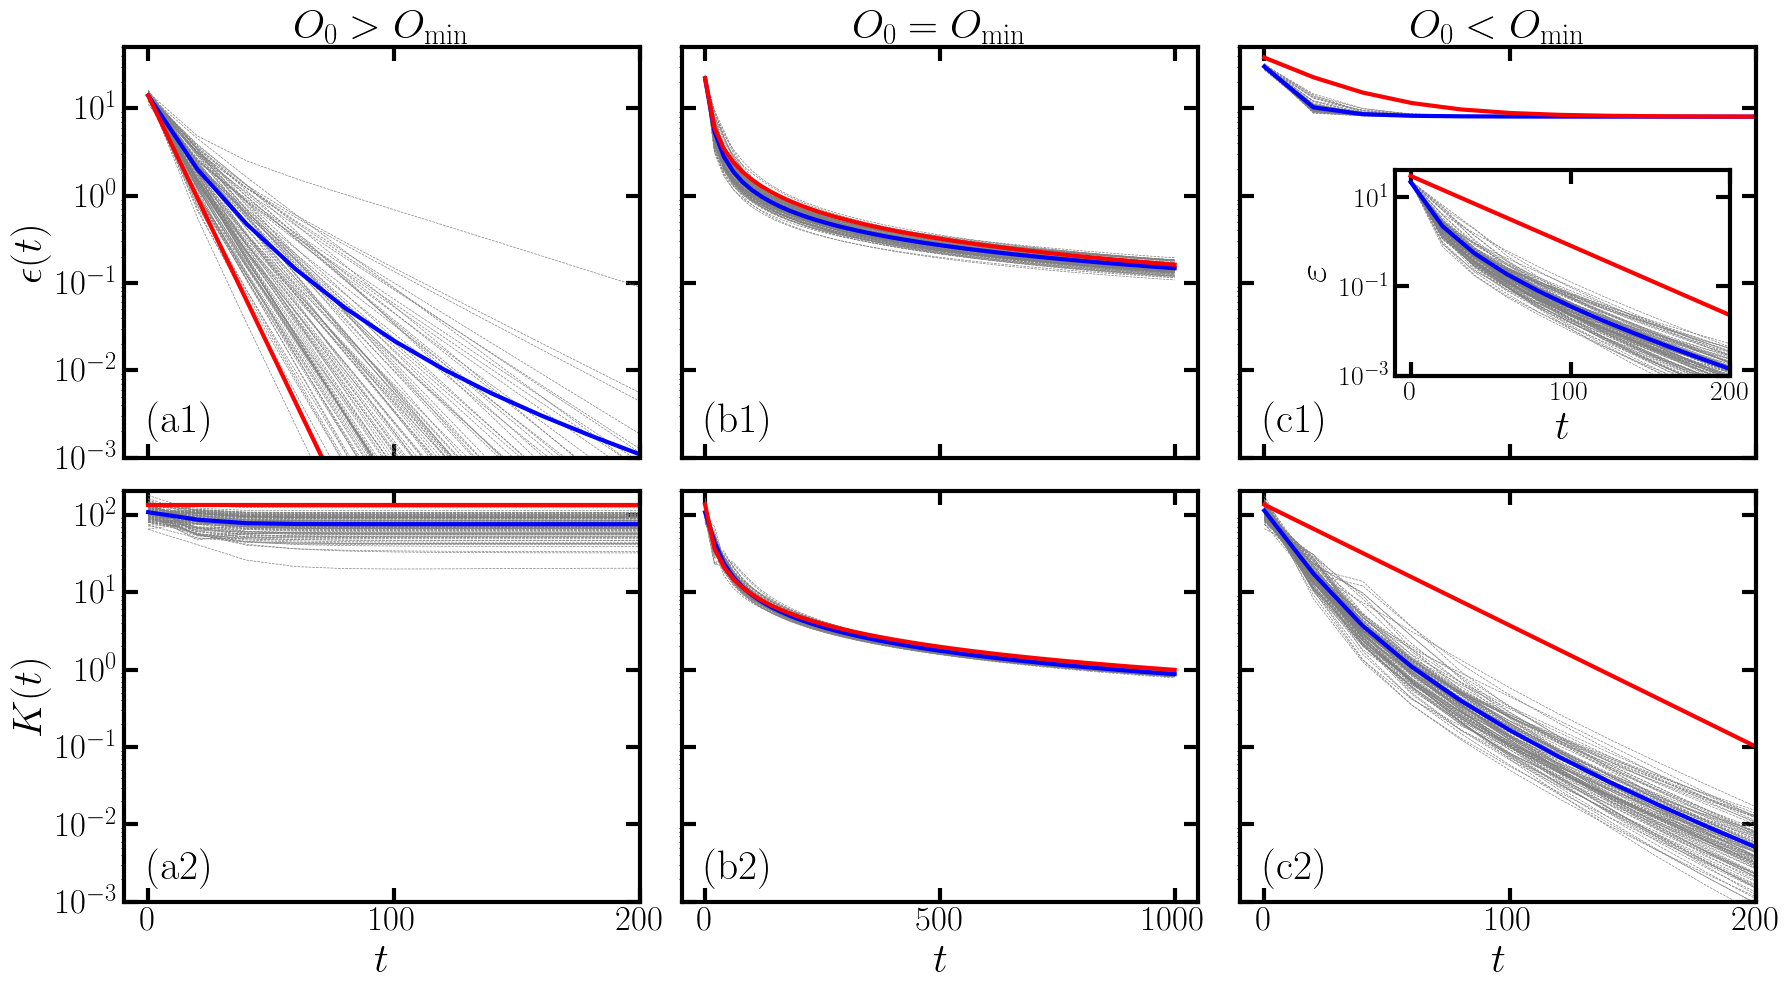

In [18]:
n = 6
d = 2**n
J = 2
E0 = J*(1-2*n)
O0_list = [-14, -22, -30]
R_list = [min(x+22, 0) for x in O0_list]

eta = 1e-3
L = 4*n

ts = np.arange(51)*20
eps_list = np.zeros((3, 51, 100))
K_list = np.zeros((3, 51, 100))
for i in range(3):
    eps_list[i] = np.load('data/training/qubits/HEA/Heisenberg/n%d/HEAepsHistXXZ_n%dL%dTgt%s.npy'
                          %(n, n, L, O0_list[i]))
    K_list[i] = np.load('data/training/qubits/HEA/Heisenberg/n%d/HEAKHistXXZ_n%dL%dTgt%s.npy'
                        %(n, n, L, O0_list[i]))

K0 = (1 + J**2)* L*(2*n) * n / 2**n

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
# O_0 = -4
axs[0,0].plot(ts, eps_list[0,:,:100], '--', lw=0.5, c='grey')
axs[0,0].plot(ts, np.mean(eps_list[0], axis=1)- R_list[0], lw=3, c='b')
axs[0,0].plot(ts, -O0_list[0]*np.exp(-eta* K0* ts), lw=3, c='r')
axs[0,0].set_xlim(-10, 200)

axs[1,0].plot(ts, K_list[0,:,:100], '--', lw=0.5, c='grey')
axs[1,0].plot(ts, np.mean(K_list[0], axis=1), lw=3, c='b')
axs[1,0].plot(ts, K0*np.ones_like(ts), lw=3, c='r')
axs[1,0].set_xlim(-10, 200)

# O_0 = -6
axs[0,1].plot(ts, eps_list[1,:,:100], '--', lw=0.5, c='grey')
axs[0,1].plot(ts, np.mean(eps_list[1], axis=1), lw=3, c='b')
axs[0,1].plot(ts, -O0_list[1]/(1 + eta* K0 *ts), lw=3, c='r')

axs[1,1].plot(ts, K_list[1,:,:100], '--', lw=0.5, c='grey')
axs[1,1].plot(ts, np.mean(K_list[1], axis=1), lw=3, c='b')
axs[1,1].plot(ts, 1/(1/K0 + eta*ts), lw=3, c='r')

# O_0 = -8
axs[0,2].plot(ts, eps_list[2,:,:100], '--', lw=0.5, c='grey')
axs[0,2].plot(ts, np.mean(eps_list[2], axis=1), lw=3, c='b')
lamd = 6*L/d
q = -2*eta * R_list[2] *lamd
axs[0,2].plot(ts, K0/(2*lamd)*np.exp(-q *ts) - R_list[2], lw=3, c='r')
axs[0,2].set_xlim(-10, 200)

# varepsilon
inset_ax = axs[0,2].inset_axes([0.3, 0.2, 0.65, 0.5])
inset_ax.plot(ts, eps_list[2,:,:100] + R_list[2], '--', lw=0.5, c='grey')
inset_ax.plot(ts, np.mean(eps_list[2], axis=1) + R_list[2], lw=3, c='b')
lamd = (6*L/d)
q = -2*eta * R_list[2] *lamd
inset_ax.plot(ts, K0/(2*lamd)*np.exp(-q *ts), lw=3, c='r')
inset_ax.set_xlabel(r'$t$', fontsize=30)
inset_ax.set_ylabel(r'$\varepsilon$', fontsize=30)
inset_ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=20)
inset_ax.set_yscale('log')
inset_ax.set_ylim(1e-3, 40)
inset_ax.set_xlim(-10, 200)

axs[1,2].plot(ts, K_list[2,:,:100], '--', lw=0.5, c='grey')
axs[1,2].plot(ts, np.mean(K_list[2], axis=1), lw=3, c='b')
axs[1,2].plot(ts, K0*np.exp(-q* ts), lw=3, c='r')
axs[1,2].set_xlim(-10, 200)

axs[0,0].set_ylabel(r'$\epsilon(t)$', fontsize=30)
axs[1,0].set_ylabel(r'$K(t)$', fontsize=30)

compare_ops = ['>', '=', '<']
for i in range(3):
    axs[0, i].set_ylim(1e-3, 50)
    axs[1, i].set_ylim(1e-3, 200)
    axs[0, i%3].set_xticklabels([])
    axs[1, i].set_xlabel(r'$t$', fontsize=30)
    axs[0, i].set_title(r'$O_0%s O_{\rm min}$'%compare_ops[i], fontsize=30)
    axs[0, i].text(x=0, y=2e-3, s=r'$\rm (%s1)$'%(chr(i + ord('a'))), fontsize=30)
    axs[1, i].text(x=0, y=2e-3, s=r'$\rm (%s2)$'%(chr(i + ord('a'))), fontsize=30)

for i in range(6):
    axs[i//3, i%3].set_yscale('log')
    if i%3:
        axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].tick_params(direction='in', length=10, width=3, top='on', right='on', 
                               labelsize=25)

plt.tight_layout()

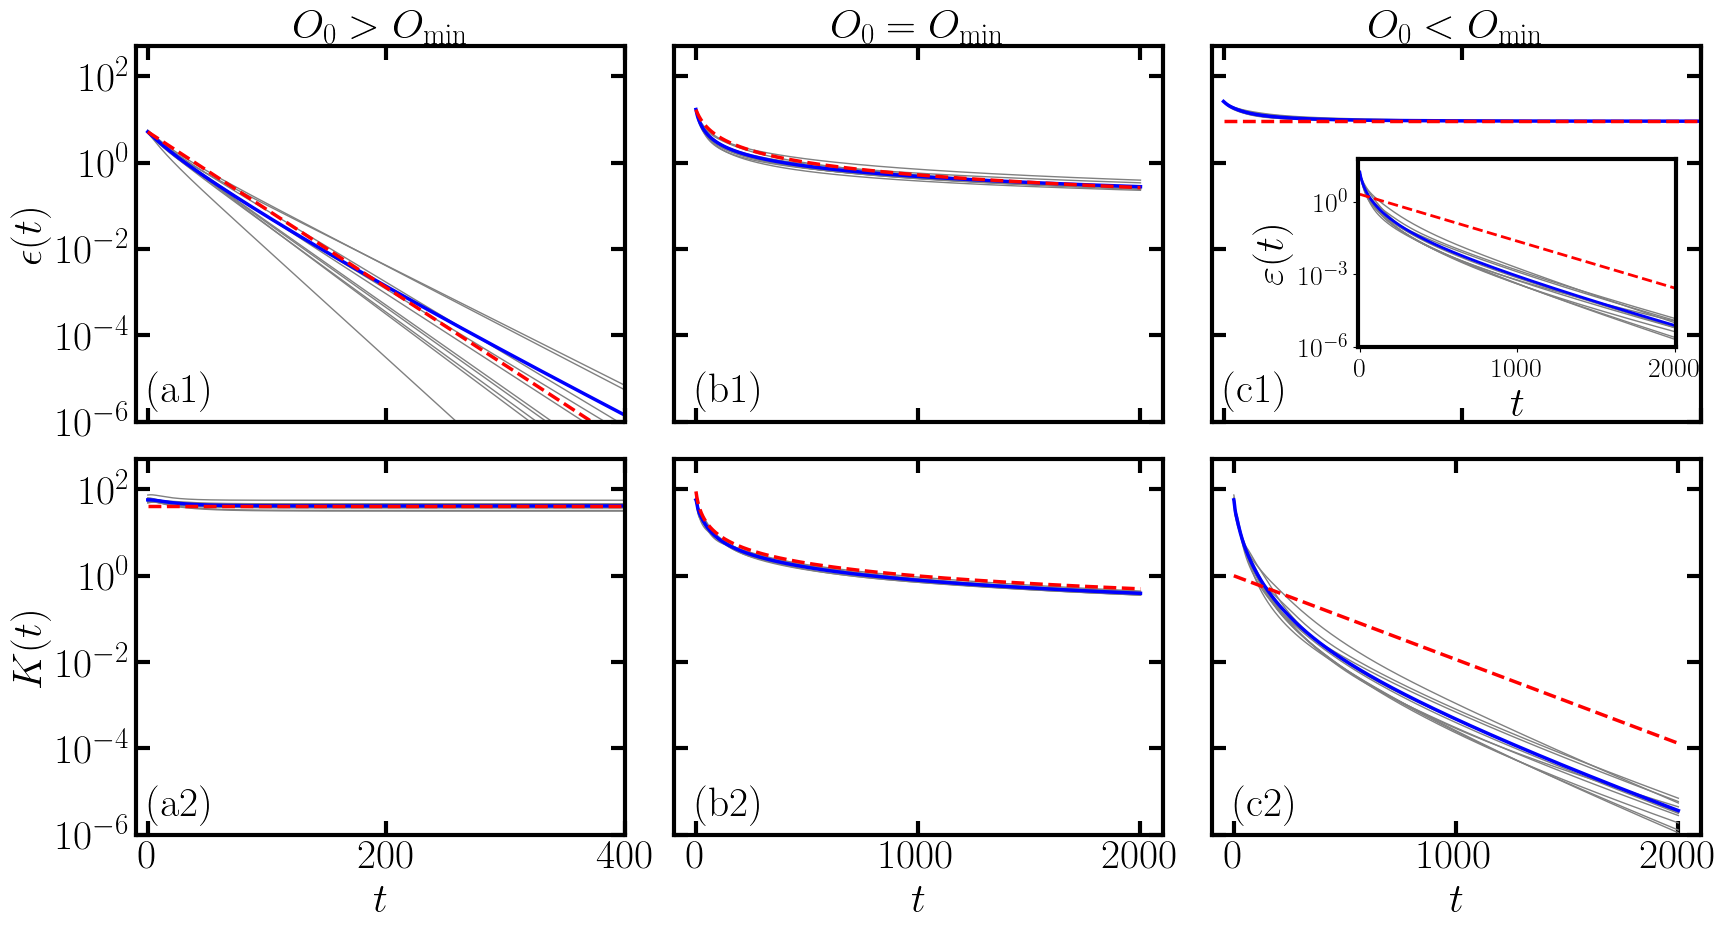

In [98]:
n = 8
O = tfim(n, 2)
O0_list = [-5, O.groundstate()[0], -26]
eta = 1e-3
D = 48
L = 2*n*D

ts = np.arange(2001)
eps_list = np.zeros((3, 2001, 10))
K_list = np.zeros((3, 2001, 10))
for i in range(3):
    eps_list[i] = np.load(f'data/Training/HEA/Ising/n{n}/HEAepshistTFIM_n{n}D{D}Tgt{O0_list[i]}.npy')
    K_list[i] = np.load(f'data/Training/HEA/Ising/n{n}/HEAKhistTFIM_n{n}D{D}Tgt{O0_list[i]}.npy')
mus = np.zeros((3, 10))
for i in range(3):
    mus[i] = np.load(f'data/Training/HEA/Ising/n{n}/HEAmusTFIM_n{n}D{D}Tgt{O0_list[i]}.npy')
ldas = np.mean(mus, axis=1)/np.mean(K_list[:,-1], axis=1)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0,0].plot(ts, eps_list[0], lw=1, c='grey')
axs[0,0].plot(ts, np.mean(eps_list[0], axis=1), lw=2.5, c='b')
axs[0,0].plot(ts, np.mean(eps_list[0,0])*np.exp(-eta*np.mean(K_list[0,-1]) * ts), '--', lw=2.5, c='r')
axs[0,0].set_ylim(1e-6, 100)
axs[0,0].set_xlim(-10, 400)

axs[1,0].plot(ts, K_list[0], lw=1, c='grey')
axs[1,0].plot(ts, np.mean(K_list[0], axis=1), lw=2.5, c='b')
axs[1,0].plot(ts, np.mean(K_list[0,-1])*np.ones(2001), '--', lw=2.5, c='r')
axs[1,0].set_xlim(-10, 400)

axs[0,1].plot(ts, eps_list[1], lw=1, c='grey')
axs[0,1].plot(ts, np.mean(eps_list[1], axis=1), lw=2.5, c='b')
axs[0,1].plot(ts, 1/(-1/O0_list[1] + ldas[1]*2*eta*ts), '--', lw=2.5, c='r')

axs[1,1].plot(ts, K_list[1], lw=1, c='grey')
axs[1,1].plot(ts, np.mean(K_list[1], axis=1), lw=2.5, c='b')
axs[1,1].plot(ts, 1/(eta*ts + 1/90), '--', lw=2.5, c='r')

axs[0,2].plot(ts, eps_list[2], lw=1, c='grey')
axs[0,2].plot(ts, np.mean(eps_list[2], axis=1), lw=2.5, c='b')
R = O0_list[1]-O0_list[2]
axs[0,2].plot(ts, R*np.ones(2001), '--', lw=2.5, c='r')
axs[0,2].set_xlim(-10, 400)

# varepsilon
inset_ax = axs[0,2].inset_axes([0.3, 0.2, 0.65, 0.5])
inset_ax.plot(ts, eps_list[2] - R, lw=1, c='grey')
inset_ax.plot(ts, np.mean(eps_list[2], axis=1) - R, lw=2, c='b')
inset_ax.plot(ts, np.exp(-2*eta*ldas[2]*R*ts)/(2*ldas[2]), '--', lw=2, c='r')
inset_ax.set_xlabel(r'$t$')
inset_ax.set_ylabel(r'$\varepsilon(t)$')
inset_ax.set_yscale('log')
inset_ax.set_ylim(1e-6, 60)
inset_ax.set_xticks([0, 1000, 2000])
inset_ax.set_yticks([1e-6, 1e-3, 1])
inset_ax.set_xlim(-10, 2010)
inset_ax.tick_params(labelsize=20)

axs[1,2].plot(ts, K_list[2], lw=1, c='grey')
axs[1,2].plot(ts, np.mean(K_list[2], axis=1), lw=2.5, c='b')
axs[1,2].plot(ts, np.exp(-2*eta*ldas[2]*R*ts), '--', lw=2.5, c='r')

axs[0,0].set_ylabel(r'$\epsilon(t)$')
axs[1,0].set_ylabel(r'$K(t)$')

compare_ops = ['>', '=', '<']
for i in range(3):
    axs[0, i].set_ylim(1e-6, 500)
    axs[1, i].set_ylim(1e-6, 500)
    axs[0, i%3].set_xticklabels([])
    axs[1, i].set_xlabel(r'$t$', fontsize=30)
    axs[0, i].set_title(r'$O_0%s O_{\rm min}$'%compare_ops[i], fontsize=30)
    axs[0, i].text(x=0, y=3e-6, s=r'$\rm (%s1)$'%(chr(i + ord('a'))), fontsize=30)
    axs[1, i].text(x=0, y=3e-6, s=r'$\rm (%s2)$'%(chr(i + ord('a'))), fontsize=30)

for i in range(6):
    axs[i//3, i%3].set_yscale('log')
    if i%3:
        axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].tick_params(direction='in', length=10, width=3, top='on', right='on')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)